# Rock-Uplift-Water

## Import declarations

In [2]:
import landlab
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, Lithology, LithoLayers, SinkFillerBarnes, DrainageDensity
from landlab.plot import imshow_grid
import numpy as np 
import time
import matplotlib.pyplot as plt

## Initialise Grid

We initialise a grid that is 100 km x 100 km wide, in units of *metres*. The boundaries are fixed at zero at the top and bottom but left closed at the east and west. Uniform noise up to 10 metres of elevation is added at all points in the landscape to allow for channelisation.

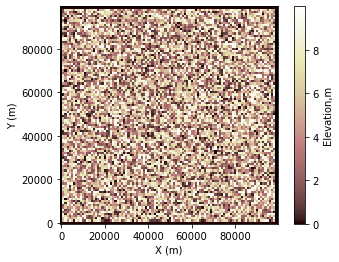

In [3]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]
imshow_grid(grid,'topographic__elevation',var_name="Elevation,m")

## Initialise Components

### Flowrouting

First we initialise the flowrouter and a sink-filler that fills in the pits in the random topography allowing for channelisation to occur. We display the drainage area that results from these calculations below.

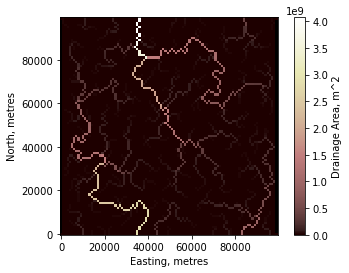

In [4]:
sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2")
plt.xlabel("Easting, metres") 
plt.ylabel("North, metres")
plt.show()

### Erosion and diffusion

Next we initialise the stream power law eroder and the linear diffuser using realistic values. 

For the parameters $n$ and $m$ we use 1, and 0.5 respectively. 

For $K_{sp}$, a reasonable range appears to be $10^{-2}$ to $10^{-4}$ m/kyr. For $D_{diff}$, a reasonable range appears to be anything less than $10^{3}$ m$^2$/kyr. These ranges are broadly supported by real-life studies e.g. ([Roberts & White](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009JB006692), [Rosenblum & Anderson](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94JB00048)), although wider ranges have been reported (e.g. see [Campforts 2015](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94JB00048))



In [5]:
n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 1 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)

peclet = ((nx*dx)*K_sp)/D_diff
print("Peclet number =",peclet)

Peclet number = 100.0


#### Time-step calculations

Using these values we now calculate the appropriate timesteps so that these advective and diffusive timesteps can be performed correctly.

For the advective model, $dt < \frac{dx}{K_{sp}}$, and for the diffusive model, $dt < \frac{dx^2}{D_{diff}}$.

In [5]:
dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

print("Advective stability condition: t < ",dt_max_adv, "kyr")
print("Diffusive stability condition: t < ",dt_max_diff, "kyr")

Advective stability condition: t <  1000000.0 kyr
Diffusive stability condition: t <  1000000.0 kyr


Hence, as long as our timestep is less than these timesteps the solutions should be stable. 

We run the model, using a timestep of 100 kyr for 50 Myr at a uniform uplift rate of 0.1 m/kyr. 

Running for 500 iterations
Time per iteration = 0.01033 s
Total runtime = 5.167 s
Peclet number = 100.0


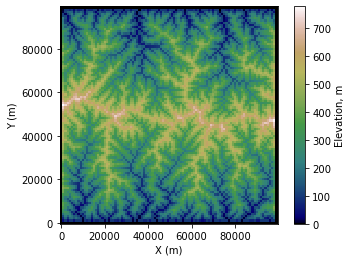

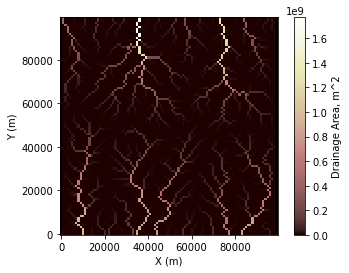

<Figure size 432x288 with 0 Axes>

In [6]:
dt = 100 # 100 kyr
uplift_rate= 0.1 # 0.1 m/kyr
runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 
print("Running for", n_steps, "iterations")

start=time.time()
for i in np.arange(n_steps):

    t=i*dt
    elev[grid.core_nodes] += uplift_rate * dt
    fr.run_one_step()
    sp.run_one_step(dt)
    diff.run_one_step(dt)
    
end=time.time()
print("Time per iteration =",round((end-start)/n_steps,5),"s")
print("Total runtime =",round((end-start),3),"s")
print("Peclet number =",peclet)
imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')
imshow_grid(grid,'drainage_area',var_name="Drainage Area, m^2", output=True)

# Exploring different combinations of Erodivility (K_sp) and Diffisuvity 
We will start by showing how varrying the K_sp, as the dominating variable for incision, and Diffusivity, as the dominating variabilty for stream incision 

## What differences do you see in the following properties with higher diffusivity in terms of:
* Drainage density
* Hillslope peak shape
* Mean elevation
* Landscape steepness


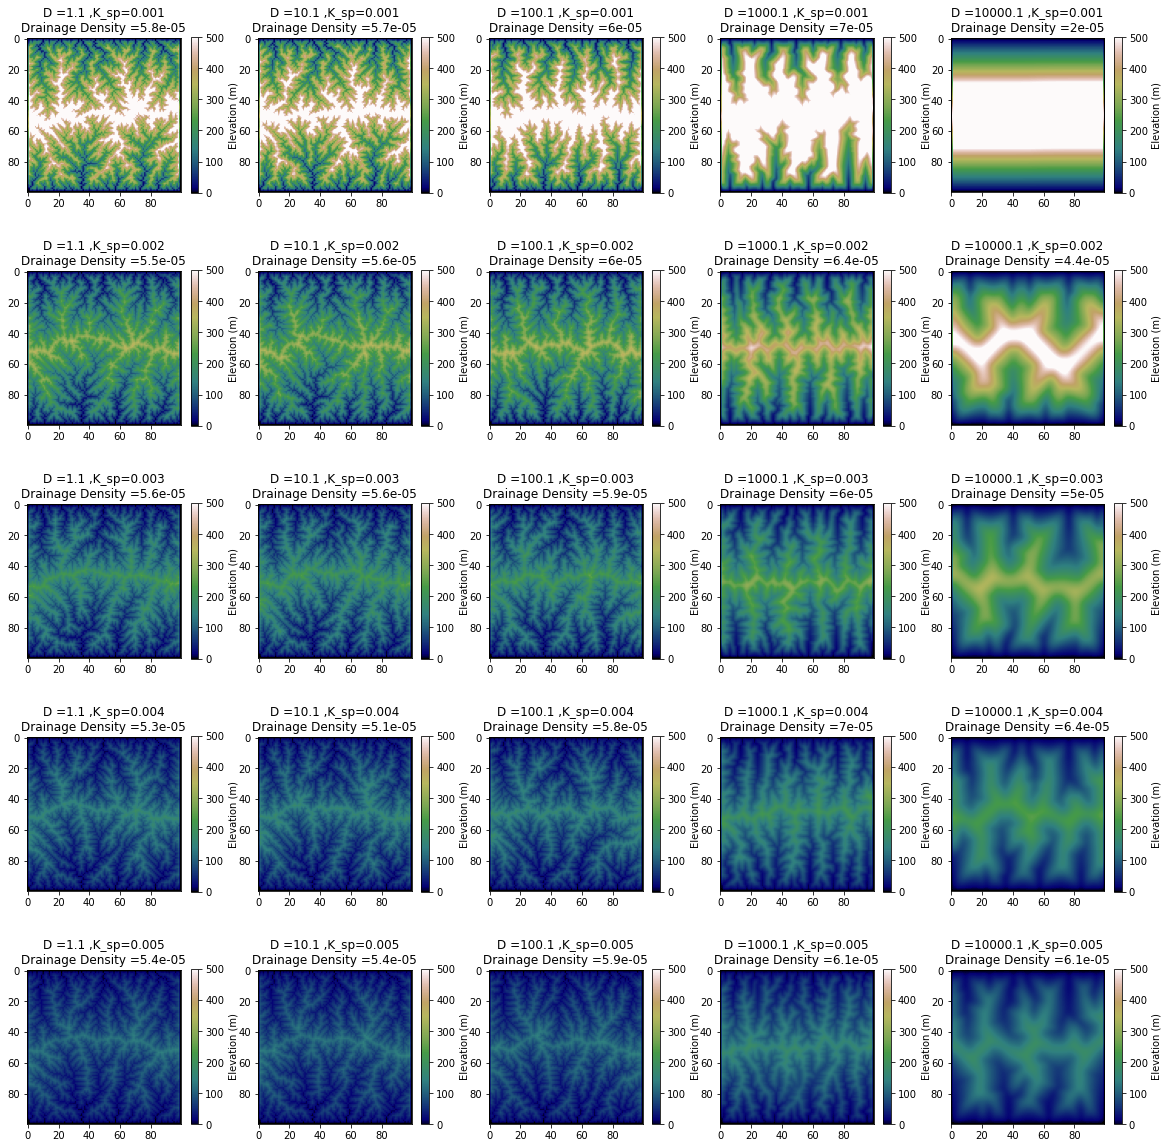

In [11]:

#Establish range of values for K_sp and D
K_sp_range = (np.arange(1, 6)) * 1e-3 #m/kyr
D_diff_range = 10 ** np.arange(0, 5)+0.1   # m^2/kyr

#Set up suplots for plotting K_sp D combinations
fig, axs = plt.subplots(nrows=len(K_sp_range), ncols=len(K_sp_range),figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)

#Lists for saving export states from each varaible combination
final_states = []
K_sp_X = []
D_diff_Y = []


for i in range(len(K_sp_range)):
    for j in range(len(D_diff_range)):
        #print("i:"+str(i) +", j:"+str(j))
        
        nx = 100 # number of grid cells (x)
        ny = 100 # number of grid cells (y)
        dx = 1000 # metres

        grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
        elev = grid.add_zeros('topographic__elevation',at='node')
        grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

        np.random.seed(1)
        elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]
        
        
        sb = SinkFillerBarnes(grid, method='D8')
        sb.run_one_step()

        fr = FlowAccumulator(grid, flow_director='D8')
        fr.run_one_step()
        
        diff = LinearDiffuser(grid,linear_diffusivity=D_diff_range[j])
        sp = FastscapeEroder(grid, K_sp=K_sp_range[i],m_sp=m_sp,n_sp=n_sp)
        
        
        dt_max_adv = grid.dx/K_sp_range[i]
        dt_max_diff = (grid.dx)**2/D_diff_range[j]

        #print("Advective stability condition: t < ",dt_max_adv, "kyr")
        #print("Diffusive stability condition: t < ",dt_max_diff, "kyr")
        
        dt = 100 # 100 kyr
        uplift_rate= 0.1 # 0.1 m/kyr
        runtime= 50000 # 50000 kyr = 50 Myr
        n_steps = runtime//dt 
       # print("D ="  + str(D_diff_range[j])  + " ,K_sp=" + str(K_sp_range[i]) )
       # print("Running for", n_steps, "iterations")
        

        for i_t in np.arange(n_steps):

            t=i_t*dt
            elev[grid.core_nodes] += uplift_rate * dt
            fr.run_one_step()
            sp.run_one_step(dt)
            diff.run_one_step(dt)
            
        #imshow_grid(grid,'topographic__elevation',var_name="Elevation, m",output=True,cmap='gist_earth')

        final_elev = grid.at_node['topographic__elevation']
        f_elev_pic = grid.node_vector_to_raster(final_elev)


        
        #plt.subplot2grid((3,3), (i,j))
        img = axs[i,j].imshow(f_elev_pic, cmap="gist_earth", vmin=0, vmax=500)
        peclet = ((nx*dx)*K_sp_range[i])/D_diff_range[j]
        
        channels = np.array(grid.at_node['drainage_area'] > 0.2e9, dtype=np.uint8)
        dd = DrainageDensity(grid, channel__mask=channels)
        mean_drainage_density = dd.calculate_drainage_density()
        #dd_list.append(mean_drainage_density)
        
        
        
        title ="D ="  + str(D_diff_range[j])  + " ,K_sp=" + str(K_sp_range[i] )   + "\n" + "Drainage Density ="
        + str(float(f'{mean_drainage_density:.6f}')) 

        axs[i,j].title.set_text(title)
        #axs[i,j].title.set_text(peclet, lo)
        cb = plt.colorbar(img, ax=axs[i,j], label = 'Elevation (m)')
        #cb.ax.set_title('Elevation (m)')
        
        
        #print("Peclet number =",peclet)

        final_states.append(grid)
        K_sp_X.append(K_sp_range[i])
        D_diff_Y.append(D_diff_range[j])
#plt.colorbar()
plt.show()        
